In [13]:
#Index Mapping 
"""
0 S_nt
1 S_wt
2 S_tp
3 S_tn
4 V_nt
5 V_wt
6 V_tp
7 V_tn
8 I_nt
9 I_wt
10 I_tn
11 Q
12 R_nt
13 R_wt
14 R_tp 
15 R_tn
16 D
"""

'\n0 S_nt\n1 S_wt\n2 S_tp\n3 S_tn\n4 V_nt\n5 V_wt\n6 V_tp\n7 V_tn\n8 I_nt\n9 I_wt\n10 I_tn\n11 Q\n12 R_nt\n13 R_wt\n14 R_tp \n15 R_tn\n16 D\n'

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc
import pandas as pd

In [142]:
def diff_eqs(input, t, parameters):
  beta = parameters[0] 
  gamma = parameters[1]
  chi = parameters[2]
  epsilon = parameters[3]
  nu = parameters[4] #Factor by which quarantining reduces transmission
  mu = parameters[5]
  tau = parameters[6] #Testing rate
  rho = parameters[7] #Result return rate
  fnr = parameters[8] #False negative rate
  fpr = parameters[9] #False positive rate
  alpha = parameters[10] #1/test validity duration

  Y = np.zeros((17)) 
  V = input
  N = np.sum(V[:16]) #Not including dead individuals
  S_effective = V[0]+V[1]+V[2]+V[3]
  V_effective = V[4]+V[5]+V[6]+V[7]
  I_active = V[8]+V[9]+V[10]
  R_total = V[12]+V[13]+V[14]+V[15]

  N = max(N, 1e-8)
  S_effective = max(S_effective, 1e-8)
  V_effective = max(V_effective, 1e-8)

  Y[0] = -beta*(I_active+nu*V[11])*V[0]/N-chi*V[0]/S_effective-tau*V[0]/(S_effective+V_effective+I_active+R_total)+alpha*(V[2]+V[3])
  Y[1] = -beta*(I_active+nu*V[11])*V[1]/N-chi*V[1]/S_effective+tau*V[0]/(S_effective+V_effective+I_active+R_total)-rho*V[1]
  Y[2] = -beta*(I_active+nu*V[11])*V[2]/N-chi*V[2]/S_effective+rho*fpr*V[1]-alpha*V[2]
  Y[3] = -beta*(I_active+nu*V[11])*V[3]/N-chi*V[3]/S_effective+rho*(1-fpr)*V[1]-alpha*V[3]
  
  Y[4] = -epsilon*(I_active+nu*V[11])*V[4]/N+chi-tau*V[4]/(S_effective+V_effective+I_active+R_total)+alpha*(V[6]+V[7])
  Y[5] = -epsilon*(I_active+nu*V[11])*V[5]/N+tau*V[4]/(S_effective+V_effective+I_active+R_total)-rho*V[5]
  Y[6] = -epsilon*(I_active+nu*V[11])*V[6]/N+rho*fpr*V[5]-alpha*V[6]
  Y[7] = -epsilon*(I_active+nu*V[11])*V[7]/N+rho*(1-fpr)*V[5]-alpha*V[7]

  Y[8] = beta*S_effective*(I_active+nu*V[11])/N+epsilon*V_effective*(I_active+nu*V[11])/N-gamma*V[8]-mu*V[8]-tau*V[8]/(S_effective+V_effective+I_active+R_total)+alpha*(V[10]+V[11])
  Y[9] = tau*V[8]/(S_effective+V_effective+I_active+R_total)-rho*V[9]-gamma*V[9]-mu*V[9]
  Y[10] = rho*fnr*V[9]-gamma*V[10]-mu*V[10]-alpha*V[10]

  Y[11] = rho*(1-fnr)*V[9]-gamma*V[11]-mu*V[11]-alpha*V[11]

  Y[12] = gamma*I_active+gamma*V[11]-tau*V[12]/(S_effective+V_effective+I_active+R_total)+alpha*(V[14]+V[15])
  Y[13] = tau*V[12]/(S_effective+V_effective+I_active+R_total)-rho*V[13]
  Y[14] = rho*fpr*V[13]-alpha*V[14]
  Y[15] = rho*(1-fpr)*V[13]-alpha*V[15]

  Y[16] = mu*I_active+mu*V[11]
  return Y

In [143]:
starting_infections = 0.001 # 0.1% of the total popultion starts off infected
starting_vaccinations = 0.001
INPUT_0 = np.array([1-starting_infections-starting_vaccinations, 0, 0, 0, starting_vaccinations, 0, 0, 0, starting_infections, 0, 0, 0, 0, 0, 0, 0, 0])*10**6 # Initial values of SIRVQD scaled to a population of one million
R0 = 4.22
CFR = 0.1 # Case fatality rate
gamma = 0.0714*(1-CFR)
mu = 0.0714*CFR
beta = R0*(gamma+mu)

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [144]:
param_bounds = {
    'chi': (0.001*10**6, 0.01*10**6),
    'epsilon': (0, beta),
    'nu': (0, beta),
    'tau': (0.001*10**6, 0.1*10**6),
    'rho': (0, 1),
    'fnr': (0, 0.2), 
    'fpr': (0, 0.05),
    'alpha': (0, 0.33)
}

param_names = list(param_bounds.keys())

In [145]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [146]:
def simulate_model(params): 
    chi, epsilon, nu, tau, rho, fnr, fpr, alpha = params
    all_params = np.array([beta, gamma, chi, epsilon, nu, mu, tau, rho, fnr, fpr, alpha])

    RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

    I_model = RES_init[:, 8] + RES_init[:, 9] + RES_init[:, 10] #Compare the infected to the target data
    V_model = RES_init[:, 4] + RES_init[:, 5] + RES_init[:, 6] + RES_init[:, 7] #Compare the vaccinated to the target data
    D_model = RES_init[:, 16]
    return I_model, V_model, D_model 

In [147]:
def MSE_func(params, I_data, V_data, D_data): 
    I_model, V_model, D_model = simulate_model(params)
    I_model = I_model[:len(I_data)]
    V_model = V_model[:len(V_data)]
    D_model = D_model[:len(D_data)]
    return np.mean((I_model - I_data) ** 2) + np.mean((V_model - V_data) ** 2) + np.mean((D_model - D_data) ** 2)

In [148]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTjjGeQs360iLthLJnORDYl_ySLcsT0yZ5b4Az31CvcM5j5dnelZCbeZrIZ29aApBP-miFLKwGP2M8_/pub?output=csv'
df = pd.read_csv(url)
df.columns

Index(['DATE', 'TOTAL DEATHS (RAW)', 'TOTAL DEATHS (TO USE)',
       'TOTAL RECOVERIES (RAW)', 'TOTAL RECOVERIES (TO USE)', 'TOTAL CASES ',
       'TOTAL REMOVALS R(t) = total deaths + total recoveries',
       'ACTIVE CASES I(t) = total cases - (total deaths + total recoveries)',
       'V(t)', 'dV/dt', 'dI/dt',
       'SUSCEPTIBLE INDIVIDUALS S(t) = population - I(t) - R(t)', 'Day', 'B',
       'Fixed B (average of increments to the left)', 'Unnamed: 15',
       'Source: https://en.wikipedia.org/wiki/Template:COVID-19_pandemic_data/France_medical_cases_chart'],
      dtype='object')

In [149]:
I_data = df['TOTAL CASES '].to_numpy()[162:262]
D_data = df['TOTAL DEATHS (TO USE)'].to_numpy()[162:262]
V_data = df['V(t)'].to_numpy()[162:262]

In [150]:
#Loop over all samples and track the best 
# I_data = np.linspace(0.001 * 10**6, 10000, 100) + np.random.normal(0, 10, 100) #Change later on to be real data
# V_data = np.linspace(100, 0.01 * 10**6, 100) + np.random.normal(0, 100, 100)
# V_data = np.clip(V_data, 0, None) 
# D_data = np.linspace(1, 200, 100) + np.random.normal(0, 5, 100)
# D_data = np.clip(D_data, 0, None)

best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data, V_data, D_data)
    if error < lowest_error: 
        lowest_error = error
        best_params = sample 
print("Best parameter set:", dict(zip(param_names, best_params)))

Best parameter set: {'chi': 9999.208875315191, 'epsilon': 0.11726722295594771, 'nu': 0.26241309656931605, 'tau': 43892.31041545365, 'rho': 0.9828036498968827, 'fnr': 0.13195289221781878, 'fpr': 0.04396275528501168, 'alpha': 0.2514858586537379}


In [151]:
#Simulate model using the best parameter choices 
chi, epsilon, nu, tau, rho, fnr, fpr, alpha = best_params
all_params = np.array([beta, gamma, chi, epsilon, nu, mu, tau, rho, fnr, fpr, alpha])
RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

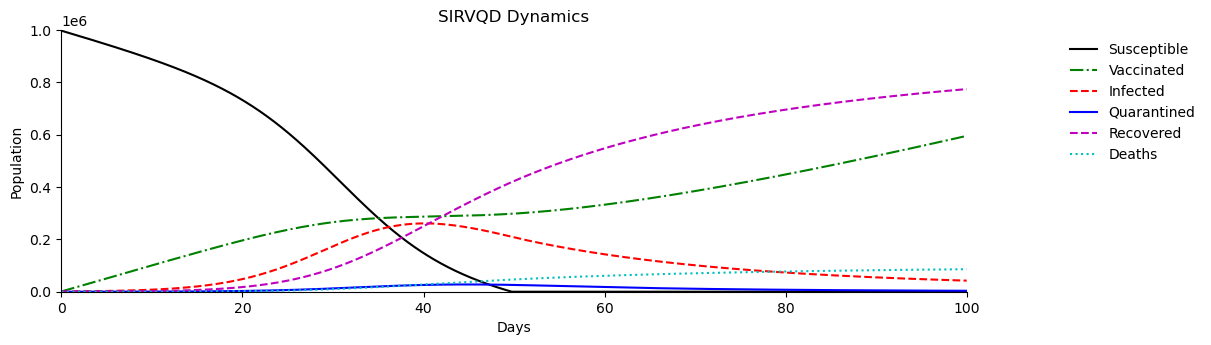

In [153]:
fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

t_vals = np.arange(0, ND_end + t_inc, t_inc)

S_total = RES_init[:, 0] + RES_init[:, 1] + RES_init[:, 2] + RES_init[:, 3] # S_nt + S_wt + S_tp + S_tn 
V_total = RES_init[:, 4] + RES_init[:, 5] + RES_init[:, 6] + RES_init[:, 7] # V_nt + V_wt + V_tp + V_tn 
I_total = RES_init[:, 8] + RES_init[:, 9] + RES_init[:, 10]  # I_nt + I_wt + I_tn
Q = RES_init[:, 11]
R_total = RES_init[:, 12] + RES_init[:, 13] + RES_init[:, 14] + RES_init[:, 15]
D = RES_init[:, 16]

ax.plot(t_vals, S_total, '-k', label='Susceptible') # S
ax.plot(t_vals, V_total, '-.g', label='Vaccinated') # V
ax.plot(t_vals, I_total, '--r', label='Infected') # I
ax.plot(t_vals, Q, '-b', label='Quarantined') # Q
ax.plot(t_vals, R_total, '--m', label='Recovered') # R
ax.plot(t_vals, D, ':c', label='Deaths') # D

ax.set_xlabel('Days')
ax.set_ylabel('Population')

plt.xlim([0,ND_end])
plt.ylim([0,sum(INPUT_0)])
plt.tight_layout()
plt.title('SIRVQD Dynamics')
plt.legend(bbox_to_anchor = (1.1, 1), loc = 'upper left', frameon=False)
plt.show()